In [ ]:
#Ucitavanje biblioteka
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from google.colab import drive

## Mount-ovanje GDrive-a

Kliknuti na "Connect to Google Drive", izabrati user-a, pa kliknuti "Allow"

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Ucitavanje Podataka

Na Google Drive-u napraviti folder w2v_data i smestiti tu file train.csv

In [ ]:
#Ucitavanje podataka 
#Putanja do CSV file-a
train_path = '/content/drive/MyDrive/w2v_data/train.csv'

#Kreiranje Pandas dataframe-a
df =  pd.read_csv(train_path, parse_dates=['log_time'])

#Konverzija 'product_id' kolone u tip string (kao reci za W2V model)
df['product_id'] = df['product_id'].astype('int').astype('str')

## Analiza Dataset-a

Znacenja kolona:
- **session_id** - Jedinstven ID sesije. Jedna sesija podrazumeva jednu posetu sajtu jednog korisnika i pregledanje vise proizvoda.
- **log_time** - Vreme gledanja proizvoda
- **product_id** - Jedinstven ID proizvoda
- **price** - Cena proizvoda
- **cat_name** - Ime kategorije proizvoda

In [ ]:
#Prvih 10 redova tabele
df.head(10)

,session_id,log_time,product_id,price,cat_name
0,g66e0tjr7s5qrgojd7tregs1c1,2021-03-09 13:46:58,6291,23.24,Šolje i čajnici
1,asmovt9e9v4iok6ldl6s63gmr6,2021-03-09 13:47:50,6291,23.24,Šolje i čajnici
2,jkvi9skjtb0g4tchoo602r2ur6,2021-03-09 13:50:25,6287,23.24,Setovi za kafu
3,jkvi9skjtb0g4tchoo602r2ur6,2021-03-09 14:00:42,6285,23.24,Setovi za kafu
4,58qtdis95hk0jovnassa28t1t2,2021-03-09 14:02:56,9448,5.99,Setovi za kafu
5,58qtdis95hk0jovnassa28t1t2,2021-03-09 14:05:27,9452,5.99,Setovi za kafu
6,g66e0tjr7s5qrgojd7tregs1c1,2021-03-09 14:12:40,7334,13.12,Šerpe i lonci
7,8bo3k75kkr270pakqjjfk49j15,2021-03-09 14:16:34,9448,5.99,Setovi za kafu
8,8bo3k75kkr270pakqjjfk49j15,2021-03-09 14:17:06,9451,5.99,Setovi za kafu
9,vev9gf4js669m1bn96g6041lq5,2021-03-09 14:17:15,1921,26.45,Šerpe i lonci


In [ ]:
#Broj redova tabele (pregleda razlicitih proizvoda)
nrows = len(df)
print('Broj redova table: {}'.format(nrows))

Broj redova table: 45679


In [ ]:
#Broj razlicitih sesija 
nsessions = df['session_id'].nunique()
print('Broj razlicitih sesija: {}'.format(nsessions))

Broj razlicitih sesija: 12342


In [ ]:
#Zadatak - Broj razlicitih prozvoda 
nproducts = df['product_id'].nunique()
print('Broj razlicitih poizvoda: {}'.format(nproducts))

Broj razlicitih poizvoda: 100


In [ ]:
#10 proizvoda sa najvecim brojem pregleda i broj pregleda
df['product_id'].value_counts()[:10]

9528     1299
10335    1283
328      1260
10339    1174
10332     944
10764     908
10331     888
10767     858
8874      856
2339      831
Name: product_id, dtype: int64

In [ ]:
#Vremenski period 
start_time = df['log_time'].min()
end_time = df['log_time'].max()

print('Period od {} do {}'.format(start_time, end_time))

Period od 2021-03-09 13:46:58 do 2022-02-26 23:35:02


In [ ]:
#Zadatak - Minimalna i maksimalna cena 
min_price = df['price'].min()
max_price = df['price'].max()

print('Cena od {} do {}'.format(min_price, max_price))

Cena od 2.99 do 546.21


In [ ]:
#Broj razlicitih kategorija 
ncategories = df['cat_name'].nunique()
print('Broj razlicitih kategorija: {}'.format(ncategories))

Broj razlicitih kategorija: 26


In [ ]:
#Zadatak - 5 kategorija sa najvise pregled i broj pregleda
df['cat_name'].value_counts()[:5]

Setovi za kafu                              14535
Servisi za ručavanje                        12150
Šerpe i lonci                                4523
Etažeri, tacne, činije, setovi za kolače     2572
Setovi posuđa                                1548
Name: cat_name, dtype: int64

## Graficki prikaz podataka

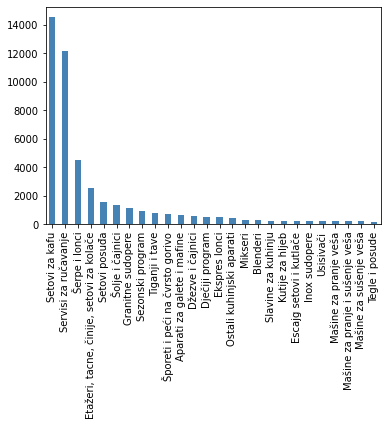

In [ ]:
#Grafik koji pokazuje broj pregleda po kategoriji
topl = df['cat_name'].value_counts()
#Crtanje bar chart-a
topl.plot(kind='bar', color='steelblue');

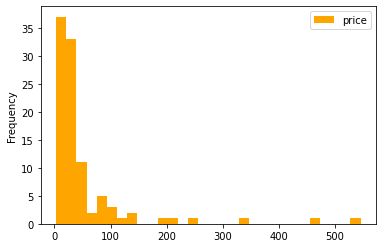

In [ ]:
#Raspodela cena
#Sacuvati samo jedan red po proizvodu
topl = df.drop_duplicates(subset=['product_id'])
#Selektovanje jedne kolone
topl = topl[['price']]
#Crtanje histograma (raspodele po vrednostima)
topl.plot.hist(bins=30, color='orange');

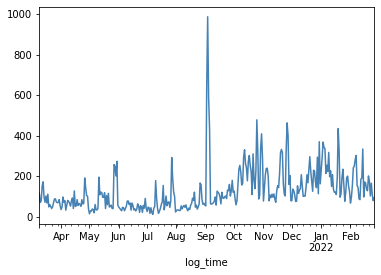

In [ ]:
#Broj ukupnih pregeda po danu
topl = df
#Kolona za crtanje
topl['count'] = 1
#Postavlja se vreme za index
topl = df.set_index('log_time')
#Broj pregleda po dana - '1d'
topl = topl.resample('1d').count()

topl['count'].plot(kind='line', color='steelblue');

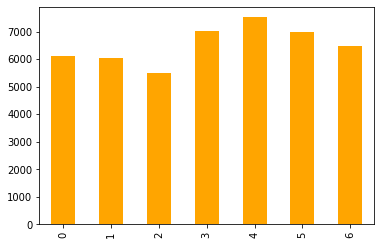

In [ ]:
#Broj pregleda po danu u nedelji - Ponedeljak=0 ... Nedelja=6
topl = df
#Dan u nedelji
topl['dayofweek'] = topl['log_time'].dt.dayofweek
#Broj pregleda po danu u nedelji i sortiranje po danu u nedelji
topl = topl['dayofweek'].value_counts().sort_index()

topl.plot(kind='bar', color='orange');

## Priprema Sekvenci

In [ ]:
#Za svaku sesiju dobijamo niz ID-va pregledanih proizvoda po redosledu geldanja
#Sortiranje pregleda po vremenu
df = df.sort_values('log_time')

#Grupisanje po sesiji i pravljenje listi (sekvence)
sessions = df.groupby('session_id')['product_id'].apply(list)

print('Broj sekvenci za treniranje: {}'.format(len(sessions)))

Broj sekvenci za treniranje: 12342


In [ ]:
#Primer prvih 5 sekvenci (sesija) - brojevi u listi predstavljaju ID-eve proizvoda
sessions[0:5]

session_id
005dqg9qpcc1h169liebd8nmh5              [10411, 10413]
0099va48td37ltqa5p9hrhdkf6          [9500, 7335, 9780]
009ddn2npqeep5lie99ts72bt4        [10817, 8854, 10334]
00cfd98coo5eptoq27gspqsfv4    [9528, 9528, 9528, 9528]
00jlad83rv5k223dh82j6llgu1          [9529, 9529, 9529]
Name: product_id, dtype: object

## Treniranje W2V Modela

In [ ]:
#Konstante
#Duzina embedding vectora
size = 32
#Postavljanje seed-a za random generator zbog reproduktabilnosti eksperimenata
seed = 13
#Biranje skip-gram modela
sg = 1

#Kreiranje i treniranje model-a
w2v = Word2Vec(sessions.values,  size=size,  seed=seed, sg=sg)

## Kreiranje preporuka

In [ ]:
#ID jednog proizvoda
product_id = '10411'

In [ ]:
#Primer jednog vektora
vec = w2v.wv[product_id]
print('Duzina vektora: {}\nVektor:\n{}'.format(len(vec), vec))

Duzina vektora: 32
Vektor:
[ 0.6889399   0.10622898 -0.00826207 -0.30708575 -0.155947    0.30605543
  0.24279216 -0.52173185 -0.13524418 -0.47118968  0.48703593  0.5035826
  0.7144627  -0.16006586 -0.23126048 -0.30163094  0.34106746 -0.04758273
  0.28407255 -0.2094405  -0.17837988 -0.4058812   0.10000584  0.09980793
  0.07233538 -0.92489916  0.06025057  0.17596251  0.40952912  0.4571092
 -0.6565966   0.1991431 ]


In [ ]:
#5 najslicnijih proizvoda  za proizvod '10411'
#ID Proizvoda/ Mera Slicnosti na osnovu kosinusne slicnosti embedding vektora
w2v.wv.most_similar(product_id, topn=5)

[('10412', 0.9804485440254211),
 ('5904', 0.9377164840698242),
 ('9528', 0.9116204977035522),
 ('9770', 0.8850266337394714),
 ('9361', 0.8118312954902649)]

In [ ]:
#Kreiranje 5 preporuka za svaki proizvod
#Kod je malo komplikovaniji. Preskociti razmatranje samog koda funkcije.
def create_recommendations(df, w2v, num_recommendations=5):
        #Recommender
        rec_cols = ['product_id', 'recommended_id', 'rank']
        recommendations_list = []

        #All products
        all_products = df['product_id'].unique()

        for prd in all_products:
            #Check if product is in vocabulary
            if not prd in w2v.wv.vocab:
                continue
            #Get recommendations
            topn = w2v.wv.most_similar(prd, topn=num_recommendations)
            topn = pd.DataFrame(topn, columns = ['recommended_id', 'similarity'])
            #Product_id
            topn['product_id'] = prd
            #Add rank
            topn['rank'] = np.arange(1, num_recommendations + 1)

            #Add to list
            recommendations_list.append(topn[rec_cols])

        #Recommendations
        recommendations = pd.concat(recommendations_list)

        return recommendations
    
#Poziv funkcije - Kreiranje po 5 preporuka za svaki proizvod
recomm = create_recommendations(df, w2v)

#Privih 10 redova preporuka 
recomm.head(10)

,product_id,recommended_id,rank
0,6291,6286,1
1,6291,6287,2
2,6291,6288,3
3,6291,6285,4
4,6291,10341,5
0,6287,6288,1
1,6287,6286,2
2,6287,6285,3
3,6287,6291,4
4,6287,10341,5


Znacenja kolona:
- product_id - Proizvod
- recommended_id - Preporuceni proizvod 
- rank - Redosled preporucenih proizvoda dobijen po meri slicnosti

In [ ]:
#Provera da je za svaki proizvod kreirano pet preporuka. Za svaki proizvod kreira se po 5 preporuka.
df['product_id'].nunique() * 5 == len(recomm)

True

## Analiza Preporuka

In [ ]:
#Dodavanje kategorija proizvoda u tabelu sa preoprukama
#Kod je malo komplikovaniji. Preskociti razmatranje samog koda funkcije.
def add_categories(df, recomm):
    #Selektuju su dve kolone
    categories = df[['product_id', 'cat_name']]
    #Odbacuju se duplicirani redovi - Ostaje po jedna kategorija za svaki proizvod
    categories = categories.drop_duplicates()
    #Dodavanje kategorije za proizvod za koji se generise preporuka
    recomm = pd.merge(recomm, categories, left_on='product_id', right_on='product_id', suffixes=('','_prod'))
    #Dodavanje kategorije za preporuceni proizvod
    recomm =  pd.merge(recomm, categories, left_on='recommended_id', right_on='product_id', suffixes=('','_recomm'))
    #Odbacivanje suvisen kolone
    recomm = recomm.drop(columns=['product_id_recomm'])
    #Sortiranje po product_id-u i rank-u
    recomm = recomm.sort_values(['product_id', 'rank'])
    return recomm

#Dodavanje kategorija proizvoda u tabelu sa preoprukama
recomm = add_categories(df, recomm)

#Prvih deset redova
recomm.head(10)

,product_id,recommended_id,rank,cat_name,cat_name_recomm
125,1009,2508,1,Šerpe i lonci,Tiganji i tave
413,1009,1921,2,Šerpe i lonci,Šerpe i lonci
117,1009,1098,3,Šerpe i lonci,Setovi posuđa
349,1009,6790,4,Šerpe i lonci,Ostali kuhinjski aparati
104,1009,9500,5,Šerpe i lonci,Šerpe i lonci
308,10126,10129,1,Šerpe i lonci,Dječiji program
433,10126,11208,2,Šerpe i lonci,Šerpe i lonci
249,10126,9506,3,Šerpe i lonci,Džezve i čajnici
277,10126,2962,4,Šerpe i lonci,Dječiji program
422,10126,9124,5,Šerpe i lonci,Tiganji i tave


Znacenja kolona:
- product_id - Proizvod
- recommended_id - Preporuceni proizvod 
- rank - Redosled preporucenih proizvoda dobijen po meri slicnosti
- cat_name - Ime kategorije proizvoda
- cat_name_recomm - Ime kategorije preporucenog proizvoda

In [ ]:
#Zadatak - 10 najcesce preporucenih proizvoda i koliko puta su preporuceni
recomm['recommended_id'].value_counts()[:10]

9460     13
9500     12
7334     11
5590     11
9499     10
9506     10
5904     10
10717    10
9362      9
9731      9
Name: recommended_id, dtype: int64

In [ ]:
#Zadatak - Procenat preporuka iz iste kategorije 
#(preporuceni proizvod je iz iste kategorija kao proizvod za koji se daje preporuke)
#Pomoc - Deo tabele koja ima jednake vrednosti u dve kolone se dobija kao df[df['c1'] == df['c2']]
recomm_same_cat = recomm[recomm['cat_name'] == recomm['cat_name_recomm']]
proc_same_cat =  len(recomm_same_cat)  / len(recomm) * 100
print('Procenat preporuka iz iste kategorije: {:.2f}%'.format(proc_same_cat))

Procenat preporuka iz iste kategorije: 56.60%


## Bonus - TSNE Transformacija na W2V Embeding Vektorima

In [ ]:
#Ucitavanje biblioteka
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px

In [ ]:
#Selektovanje proizvoda iz top 3 kategorija
#Svi proizvodi i nihove kategorije
prod_df = df.groupby('product_id')[['cat_name']].first()
#Broj proizvoda po kategoriji
cat_df = df.groupby('cat_name')[['count']].count()
#3 kategorija sa najvise proizvoda
cat_df = cat_df.sort_values('count', ascending=False)[0:3]
#Proizvodi koji spadaju i tih 3 kategorija
emb_df = pd.merge(prod_df, cat_df, left_on='cat_name', right_index=True)

#Embedovanje proizoda u W2V vektore
w2v_vectors = w2v.wv[emb_df.index]
#TSNE transformavija
w2v_vectors_emb = TSNE(learning_rate='auto', init='random').fit_transform(w2v_vectors)
#Dodavanje x i y koordinate
emb_df['x'] = w2v_vectors_emb[:,0]
emb_df['y'] = w2v_vectors_emb[:,1]

#Iscrtavanje embedovanih W2V vektora za proizvode sa primenjenom TSNE transformacijom
px.scatter(emb_df, x='x', y='y', color='cat_name', width=820)